# Digit Recognizer 🔢

---

### Group Members:

- **Mohamed Amine Tlili**  
- **Mohamed Aziz Loukil**  
- **Mohamed Laatar**

---

## Importing Libraries 📚

In [118]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from keras.regularizers import l2
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

## Loading Data 📥


In [90]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
df = train.copy()
df_test = test.copy()

In [91]:
df.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


We can see there is one column that has the label and the rest are the image pixels!

In [92]:
#check for any missing values in train data
df.isnull().any().sum()

np.int64(0)

In [93]:
#check for any missing values in test data
df_test.isnull().any().sum()

np.int64(0)

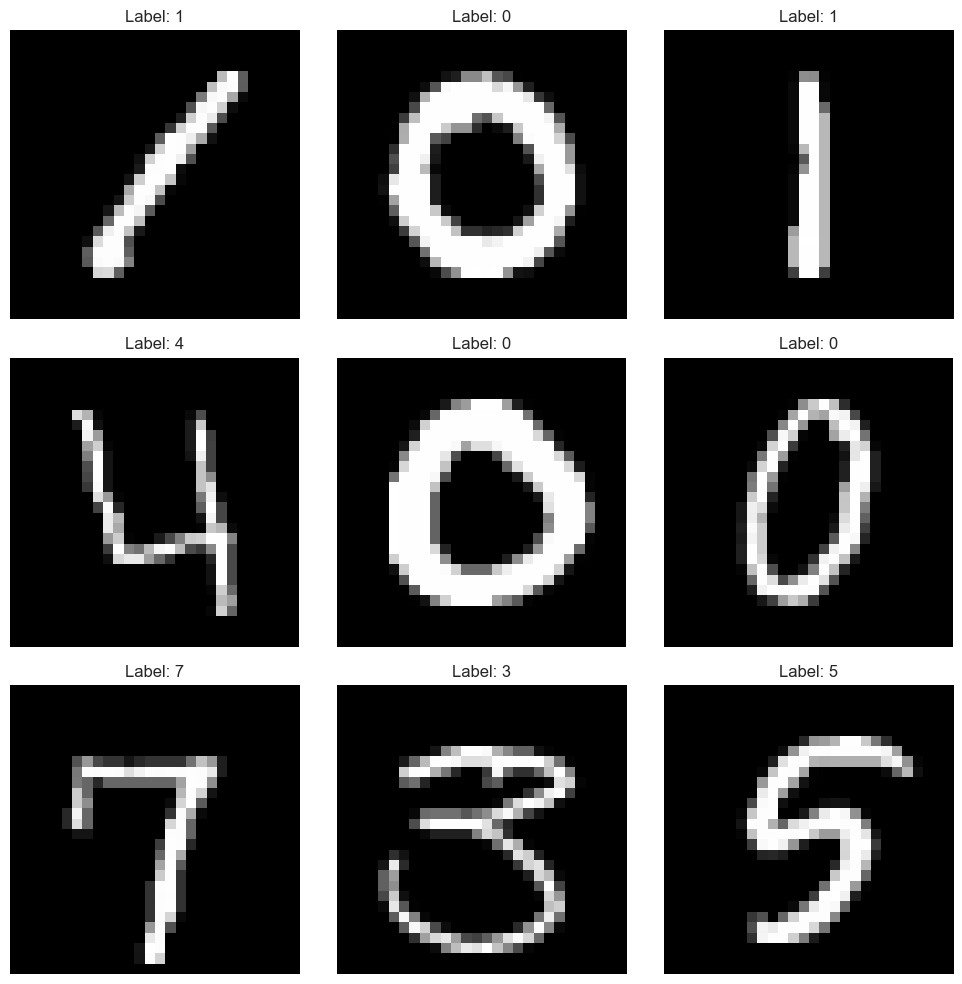

In [95]:
labels = train['label']
pixels = train.drop(columns=['label'])

# Display a few images
plt.figure(figsize=(10, 10))
for i in range(9):  # Display 9 images (3x3 grid)
    plt.subplot(3, 3, i + 1)
    img = pixels.iloc[i].values.reshape(28, 28)  # Reshape 784 values to 28x28
    plt.imshow(img, cmap='gray')  # Display in grayscale
    plt.title(f"Label: {labels.iloc[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

C:\Users\amine\AppData\Local\Temp\ipykernel_9036\3844086504.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette="viridis", edgecolor="black")


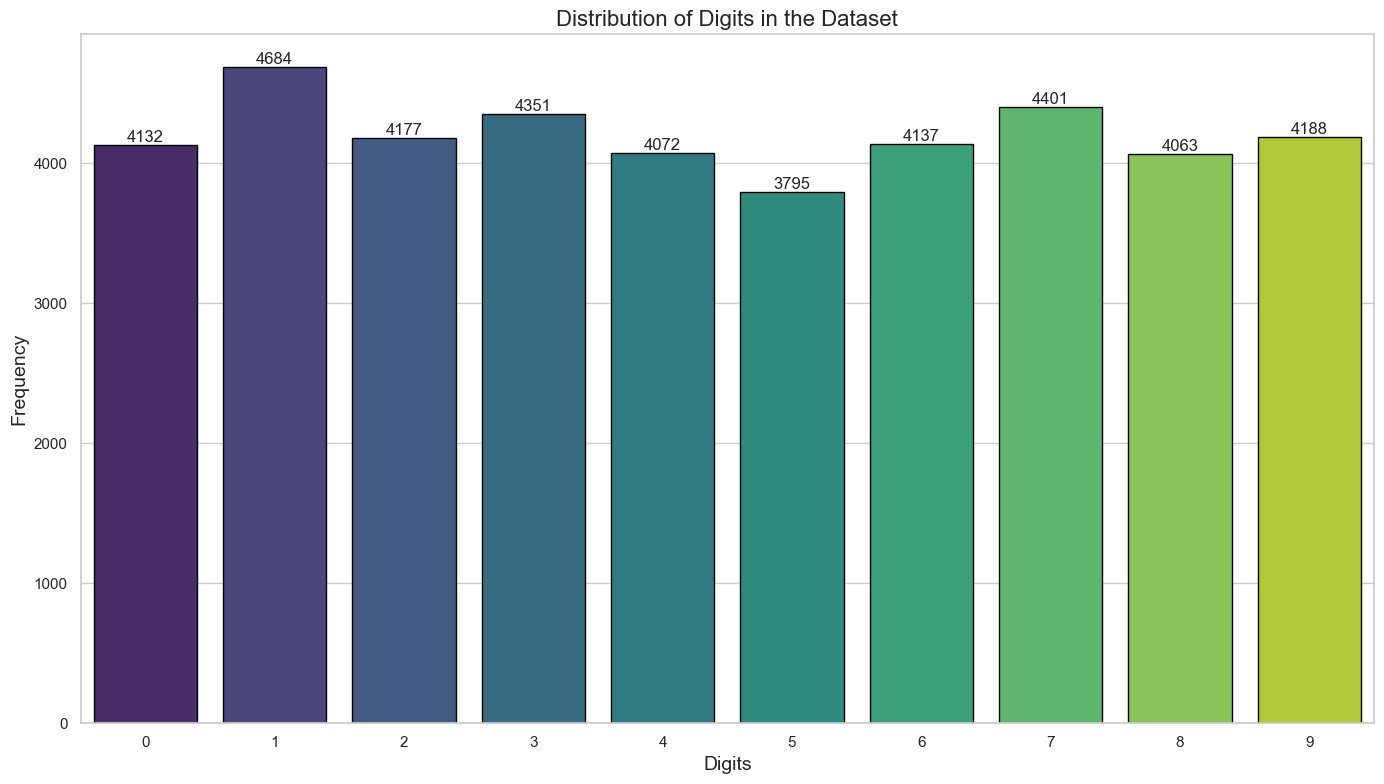

In [96]:
# Set the theme for Seaborn
sns.set_theme(style="whitegrid")

# Create the plot
plt.figure(figsize=(14, 8))
sns.countplot(x='label', data=df, palette="viridis", edgecolor="black")

# Add labels and title
plt.xlabel('Digits', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Digits in the Dataset', fontsize=16)

# Add values on top of the bars
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%d', label_type='edge', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


## Data Preprocessing 🔍

- We set a random seed to ensure that results are consistent across multiple runs, especially for operations like data splitting and weight initialization.

In [97]:
## Setting the seeds for Reproducibility.
seed = 3141
np.random.seed(seed)

### Splitting Train and Test Data

- Separate pixel values (X) from image labels (Y) in the training data.

In [98]:
# X is the pixels and Y is the image labels
X = train.iloc[:,1:]
Y = train.iloc[:,0]

#splitting dataframe using train_test_split
x_train , x_test , y_train , y_test = train_test_split(X, Y , test_size=0.1, random_state=seed)

### Reshaping Images

- We have a 1D vector with 784 pixels and we have to reshape it to (28x28x1). 

- This is because Keras wants an Extra Dimension in the end for channels. If this had been RGB images, there would have been 3 channels, but as MNIST is gray scale it only uses 1.

In [99]:
#first param in reshape is number of examples. We can pass -1 here as we want numpy to figure that out by itself

#reshape(examples, height, width, channels)
x_train = x_train.values.reshape(-1, 28, 28, 1)
x_test = x_test.values.reshape(-1, 28, 28, 1)
df_test=df_test.values.reshape(-1,28,28,1)

### Data Augmentation

Data augmentation is super important.  In terms of Images it means we can increase the number of images our model sees. 

This can be acheived by Rotating the Image, Flipping the Image, Zooming the Image, Changing light conditions, Cropping it etc.

Keep in mind doing all these things will not always help the model. For example in our situation a vertical_flip would not be wise as 6's would become 9's and vice-versa.

In [101]:
datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.1, # Randomly zoom image 
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=False,  # randomly flip images
            vertical_flip=False)  # randomly flip images

### Normalization

- Pixel values are normalized to the range [0, 1] by dividing by 255. This speeds up convergence during training and improves numerical stability.

In [100]:
#convert values to float as result will be a float. If not done vals are set to zero
x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255
df_test = df_test.astype("float32")/255

In [102]:
#fitting the ImageDataGenerator we defined above
datagen.fit(x_train)

### One hot encoding labels

The labels are given as integers between 0-9. We need to one hot encode them.

For example 4 looks like this: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

This is done so that we have labels for all the classes, and we can easily carry out the Error/Cost during BackPropogation.



In [103]:
#notice num_classes is set to 10 as we have 10 different labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(y_train[0])

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


# Building CNN Model

For image classification CNN's are the best

We construct a CNN with:

- Convolutional Layers: Extract spatial features.
- Batch Normalization: Stabilize training.
- Pooling Layers: Down-sample feature maps.
- Dropout: Prevent overfitting.
- Fully Connected Layers: Combine features for classification.

In [15]:
#Conv2d data_format parameter we use 'channel_last' for imgs

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last',
                 input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', data_format='channels_last'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid', strides=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

c:\Users\Mohamed Aziz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Compiling Model (configure learning process)

Adam Optimizer:

The Adam optimizer is widely used because it combines the advantages of two other optimizers, AdaGrad (adaptive learning rates for each parameter) and RMSProp (adaptive learning rates with momentum).

It’s efficient, requires minimal memory, and is well-suited for large datasets and complex models.
  
  Key Parameters:

- learning_rate=0.001: The initial step size for adjusting weights. A smaller learning rate ensures the optimizer takes cautious steps towards convergence.
- beta_1=0.9: The exponential decay rate for the first moment estimates (momentum). This helps smooth the gradient.
- beta_2=0.999: The exponential decay rate for the second moment estimates (variance). It helps in stabilizing the optimizer's steps.




In [104]:
from keras.optimizers import Adam

# Optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [17]:
#Compiling the model
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,606,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,213,610 (8.44 MB)

 Trainable params: 2,210,154 (8.43 MB)

 Non-trainable params: 3,456 (13.50 KB)

### Learning Rate Decay

Many optimization algorithms have a constant learning rate, which will often not reach a local minima.

To implement Learning Rate Decay we can use either LearningRateScheduler or ReduceLRonPlateau.

- LearningRateScheduler -  takes the step decay function as argument and returns updated learning rates for use in optimzer at every epoch stage.

- ReduceLRonPlateau  - monitors a quantity and if no improvement is seen for a 'patience' number of epochs, then the learning rate is reduced by a factor specified manually.

In [19]:
#for our case LearningRateScheduler will work great
reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [20]:
#visualizing what the learning rate decay will do to the learning rate through every epoch
decays = [(lambda x: 1e-3 * 0.9 ** x)(x) for x in range(10)]
i=1

for lr in decays:
    print("Epoch " + str(i) +" Learning Rate: " + str(lr))
    i+=1

Epoch 1 Learning Rate: 0.001
Epoch 2 Learning Rate: 0.0009000000000000001
Epoch 3 Learning Rate: 0.0008100000000000001
Epoch 4 Learning Rate: 0.0007290000000000002
Epoch 5 Learning Rate: 0.0006561000000000001
Epoch 6 Learning Rate: 0.00059049
Epoch 7 Learning Rate: 0.000531441
Epoch 8 Learning Rate: 0.0004782969000000001
Epoch 9 Learning Rate: 0.0004304672100000001
Epoch 10 Learning Rate: 0.0003874204890000001


### Early Stopping Rounds

- We would still like to define an early stopping parameter to ensure that our model stops training once we have reached a point where it is no longer necessary to continue training. This is another way to control overfitting.

- Its important to note that we need to specify a validation dataset in the model to use an early_stopping callback

In [21]:
#by default this is evaluated on 'val_loss'
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

Since we have the LearningRateScheduler, if we dont use the early stopping callback in this model we see an improvement from 96.4% to about 96.6% accuracy as we get closer and closer to the local minima.

## Fitting the Model

In [22]:
#defining these prior to model to increase readability and debugging
batch_size = 64
epochs = 50

In [23]:
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_test, y_test),
    verbose=1,
    steps_per_epoch=x_train.shape[0] // batch_size,
    callbacks=[reduce_lr]
)

Epoch 1/50


c:\Users\Mohamed Aziz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


590/590 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.7856 - loss: 0.7752 - val_accuracy: 0.9229 - val_loss: 0.2684 - learning_rate: 0.0010
Epoch 2/50
  1/590 ━━━━━━━━━━━━━━━━━━━━ 37s 64ms/step - accuracy: 0.9844 - loss: 0.0944

c:\Users\Mohamed Aziz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9844 - loss: 0.0944 - val_accuracy: 0.9231 - val_loss: 0.2669 - learning_rate: 9.0000e-04
Epoch 3/50
590/590 ━━━━━━━━━━━━━━━━━━━━ 36s 60ms/step - accuracy: 0.9572 - loss: 0.1401 - val_accuracy: 0.9817 - val_loss: 0.0581 - learning_rate: 8.1000e-04
Epoch 4/50
590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8750 - loss: 0.3629 - val_accuracy: 0.9800 - val_loss: 0.0629 - learning_rate: 7.2900e-04
Epoch 5/50
590/590 ━━━━━━━━━━━━━━━━━━━━ 35s 59ms/step - accuracy: 0.9687 - loss: 0.1058 - val_accuracy: 0.9881 - val_loss: 0.0419 - learning_rate: 6.5610e-04
Epoch 6/50
590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9844 - loss: 0.0823 - val_accuracy: 0.9876 - val_loss: 0.0409 - learning_rate: 5.9049e-04
Epoch 7/50
590/590 ━━━━━━━━━━━━━━━━━━━━ 35s 59ms/step - accuracy: 0.9765 - loss: 0.0761 - val_accuracy: 0.9917 - val_loss: 0.0221 - learning_rate: 5.3144e-04
Epoch 8/50
590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.000

### Evaluating the model

In [24]:
import matplotlib.pyplot as plt

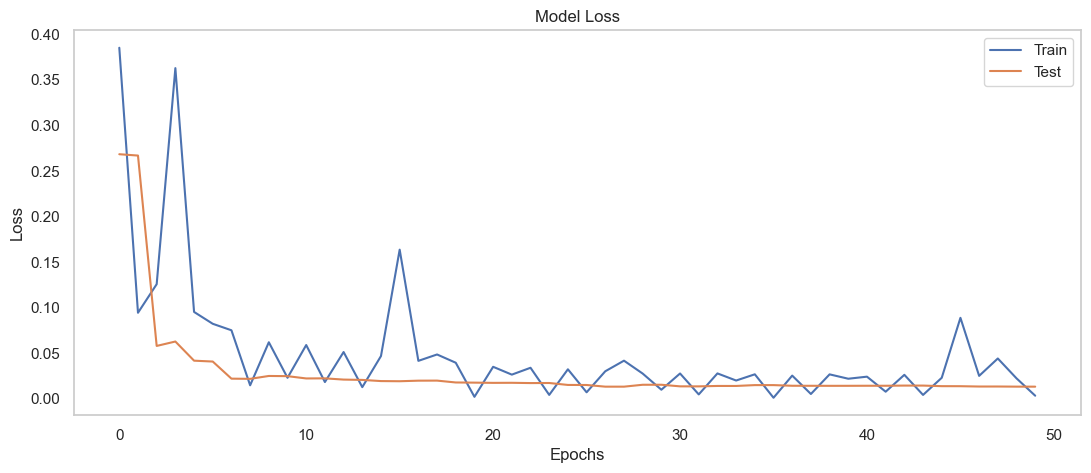

In [25]:
plt.figure(figsize=(13, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.grid()
plt.show()

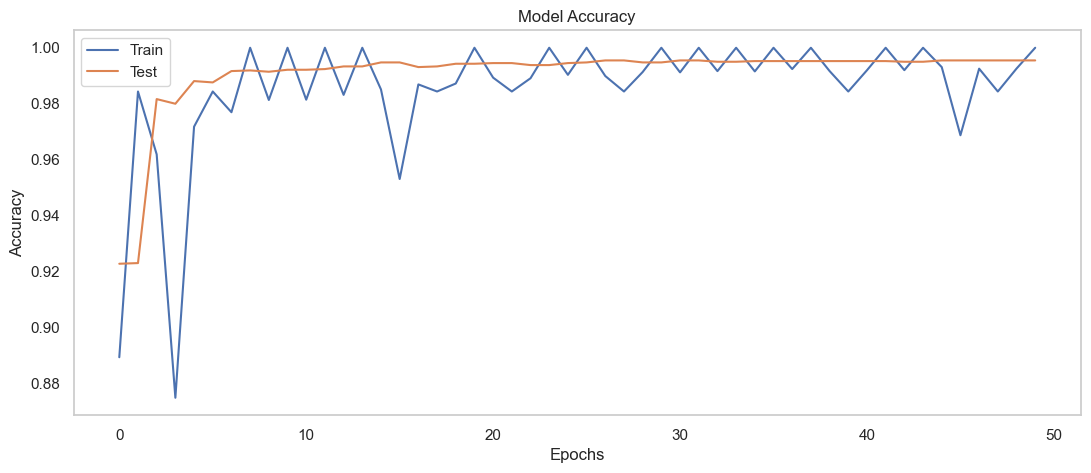

In [26]:
plt.figure(figsize=(13, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.grid()
plt.show()

Since the validation_accuracy and the accuracy are really close together we can conclude that we are not overfitting the data.

## Output prediction to CSV file

In [27]:
pred_digits_test = np.argmax(model.predict(df_test),axis=1)
image_id_test = []

for i in range (len(pred_digits_test)):
    image_id_test.append(i+1)
    
d = {'ImageId':image_id_test,'Label':pred_digits_test}
answer = pd.DataFrame(d)

answer.to_csv('answer.csv',index=False)

875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step


# Building KNN MODEL 

### Reprocessing Data for KNN

In [105]:
# Separate features and labels
X = train.iloc[:, 1:].values  # Pixels
Y = train.iloc[:, 0].values  # Labels

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=seed)

# Normalize the pixel values
x_train = x_train / 255.0
x_test = x_test / 255.0
test_data = test.values / 255.0

### Training model

In [106]:
# Define the updated parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7],  # Reduced to 3 values
    'weights': ['uniform'],     # Keeping only one option for simplicity
    'metric': ['euclidean']     # Keeping only one metric for simplicity
}

# Initialize the KNN model
knn = KNeighborsClassifier()

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(x_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found:", best_params)

# Train the model with the best parameters
best_knn = KNeighborsClassifier(**best_params)
best_knn.fit(x_train, y_train)

# Evaluate the model on the test set
y_pred = best_knn.predict(x_test)
print("Accuracy on test set with best parameters:", accuracy_score(y_test, y_pred))

# Predict on the test data
pred_digits_test = best_knn.predict(test_data)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters found: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Accuracy on test set with best parameters: 0.9709523809523809


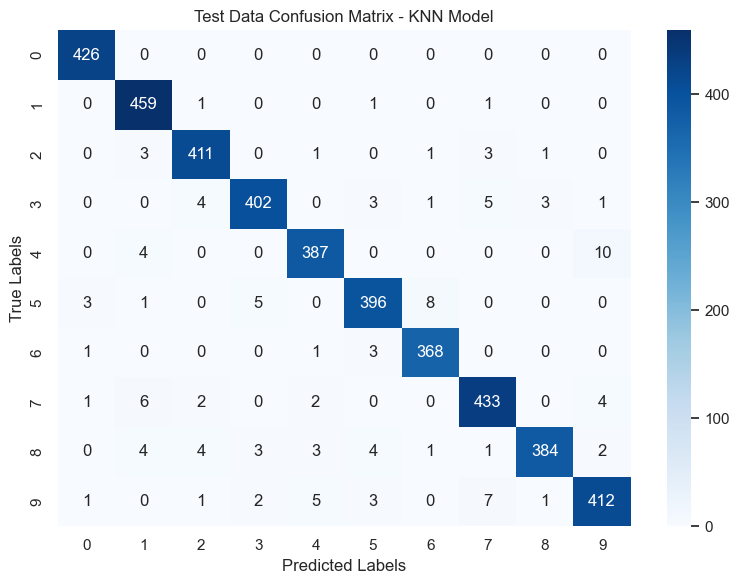

In [124]:
# If y_test is one-hot encoded, convert it to a single-label format
if len(y_test.shape) > 1:
    y_test = np.argmax(y_test, axis=1)

# Generate confusion matrix
test_conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix for the test data
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title('Test Data Confusion Matrix - KNN Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.tight_layout()
plt.show()


# Building MLP MODEL

### Reprocessing Data for MLP

In [107]:
# Prepare training and test data
X = train.iloc[:, 1:]
Y = train.iloc[:, 0]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=seed)

# Normalize the data
x_train = x_train.values.astype("float32") / 255
x_test = x_test.values.astype("float32") / 255
df_test = test.values.astype("float32") / 255

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [114]:
# Define the MLP model
model = Sequential()

# Input layer
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))

# Hidden layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=50,
                    batch_size=128,
                    callbacks=[early_stopping],
                    verbose=2)

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

Epoch 1/50
296/296 - 4s - 12ms/step - accuracy: 0.8853 - loss: 0.3750 - val_accuracy: 0.9452 - val_loss: 0.1720
Epoch 2/50
296/296 - 2s - 7ms/step - accuracy: 0.9571 - loss: 0.1432 - val_accuracy: 0.9664 - val_loss: 0.1145
Epoch 3/50
296/296 - 2s - 7ms/step - accuracy: 0.9684 - loss: 0.1010 - val_accuracy: 0.9714 - val_loss: 0.1022
Epoch 4/50
296/296 - 2s - 7ms/step - accuracy: 0.9744 - loss: 0.0820 - val_accuracy: 0.9733 - val_loss: 0.0989
Epoch 5/50
296/296 - 2s - 7ms/step - accuracy: 0.9800 - loss: 0.0626 - val_accuracy: 0.9738 - val_loss: 0.0993
Epoch 6/50
296/296 - 2s - 7ms/step - accuracy: 0.9830 - loss: 0.0524 - val_accuracy: 0.9755 - val_loss: 0.0939
Epoch 7/50
296/296 - 2s - 7ms/step - accuracy: 0.9850 - loss: 0.0465 - val_accuracy: 0.9743 - val_loss: 0.0968
Epoch 8/50
296/296 - 2s - 7ms/step - accuracy: 0.9868 - loss: 0.0419 - val_accuracy: 0.9767 - val_loss: 0.0961
Epoch 9/50
296/296 - 3s - 11ms/step - accuracy: 0.9886 - loss: 0.0369 - val_accuracy: 0.9724 - val_loss: 0.1003

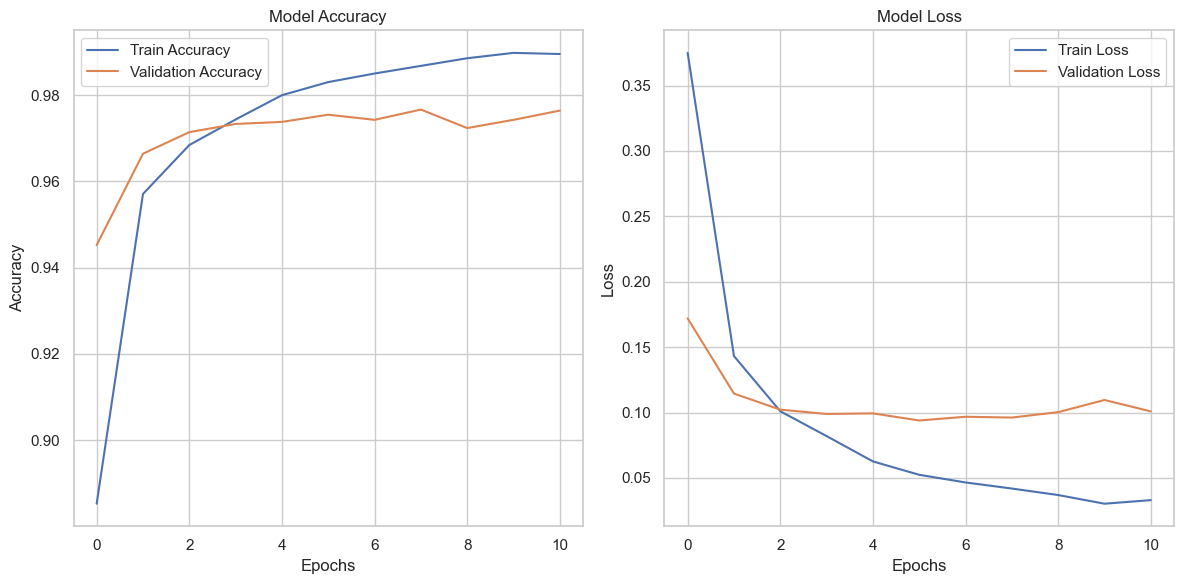

In [115]:
# Plotting the accuracy curve
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

1182/1182 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


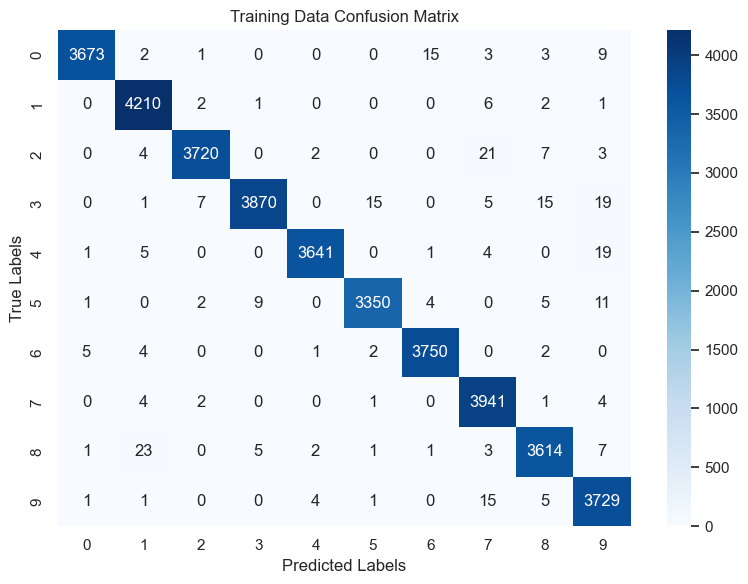

In [120]:
# Get predictions for the training set
y_train_pred = np.argmax(model.predict(x_train), axis=1)

# Convert categorical labels back to single digits
y_train_true = np.argmax(y_train, axis=1)

# Generate confusion matrix
train_conf_matrix = confusion_matrix(y_train_true, y_train_pred)

# Plotting the confusion matrix for training data
plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title('Training Data Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.tight_layout()
plt.show()

# Conclusion

After evaluating three machine learning methods—Convolutional Neural Networks (CNN), Multi-Layer Perceptron (MLP), and K-Nearest Neighbors (KNN)—on the classification task, it is clear that CNN was the most effective model. Here's a comparison of the results:

1. **CNN**: The CNN model achieved the best performance with high accuracy (around 99.55% on the test set). It showed a stable learning curve with significant improvements in both training and validation accuracy across epochs. The CNN architecture is well-suited for image classification tasks, as it can effectively capture spatial hierarchies and patterns in the data, leading to robust feature extraction and generalization.

2. **MLP**: While the MLP model also performed well with accuracy values around 98% on the validation set, it lagged slightly behind the CNN. MLPs typically require extensive tuning and might not capture spatial features as effectively as CNNs, especially in image-related tasks.

3. **KNN**: The KNN classifier showed acceptable performance but fell short in comparison to CNN. KNN relies on the distance between instances for classification, which can be computationally expensive for large datasets, and it doesn't benefit from the hierarchical feature extraction process that CNNs provide.

### Why CNN Performed the Best:
- **Feature Extraction**: CNNs excel at automatically extracting hierarchical features from images, which is a crucial advantage in image classification tasks like digit recognition.
- **Generalization**: CNNs tend to generalize better compared to traditional machine learning algorithms like KNN and MLP when dealing with image data.
- **Overfitting Control**: By using data augmentation techniques such as rotation, flipping, and zooming, CNNs can prevent overfitting, a problem that might be more pronounced in MLP or KNN models, especially on small datasets.

Thus, for image classification tasks, CNN proved to be the most powerful method due to its ability to learn from raw pixel data and capture spatial relationships more effectively than other models.